In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family'] = 'fangsong'


In [5]:
# 清洗数据集方法
def brush(workerDF):
    # print(workerDF.head())

    # 删除Employee ID和Date of Joining列
    workerDF.drop(['EmployeeID'], axis=1, inplace=True)
    workerDF.drop(['Date of Joining'], axis=1, inplace=True)
    # print(workerDF.head())

    # 将字符串类别的列转换为数字类型
    workerDF[['Gender']] = workerDF[['Gender']].apply(LabelEncoder().fit_transform)
    workerDF[['Company Type']] = workerDF[['Company Type']].apply(LabelEncoder().fit_transform)
    workerDF[['WFH Setup Available']] = workerDF[['WFH Setup Available']].apply(LabelEncoder().fit_transform)

    # 找出有缺省值的行
    sample_incompletedata = workerDF[workerDF.isnull().any(axis=1)]
    #print(sample_incompletedata.head())

    # 用列的中位数填充缺失值
    # imputer = SimpleImputer(strategy="median")
    # workerDF = imputer.fit_transform(workerDF)
    for i in workerDF.columns:
        workerDF[i] = workerDF[i].fillna(workerDF[i].mean())
    # print(workerDF.head())

    # 转化为浮点数
    workerDF = pd.DataFrame(workerDF, dtype=np.float)
    # print(workerDF.head())
    return workerDF

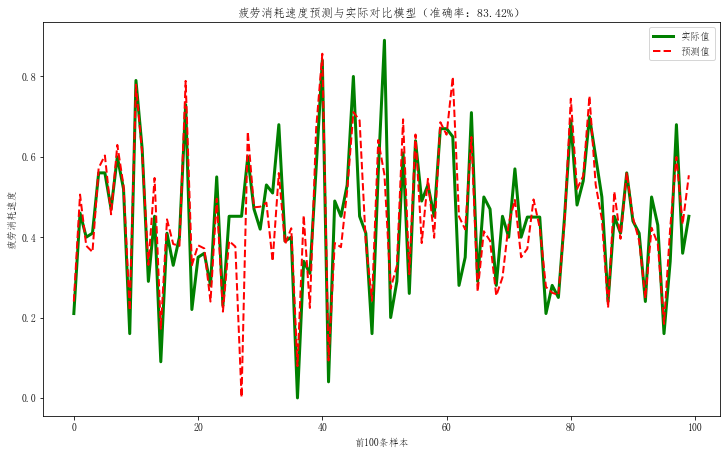

In [6]:
# 旧数据
#导入员工工作信息
data = pd.read_csv('train.csv')
workerDF = brush(data)    
# 分离训练集和测试集
wkDFdata = workerDF.drop(['Burn Rate'], axis=1)
wkDFrate = workerDF['Burn Rate']
# random_stat随机种子
Train_x, Test_x, Train_y, Test_y = train_test_split(wkDFdata, wkDFrate, test_size=0.2, random_state=42)

# 数据标准化
ss = StandardScaler().fit(Train_x)
Train_x = pd.DataFrame(ss.transform(Train_x), columns=Train_x.columns)
Test_x = pd.DataFrame(ss.transform(Test_x), columns=Test_x.columns)
# print(Train_x.head())

# 随机深林回归
model_rf = ensemble.RandomForestRegressor(n_estimators=20)
model_rf.fit(Train_x, Train_y)
rf_score = model_rf.score(Test_x, Test_y)*100
# print(rf_score) # 准确度

# 预测
rf_pred = model_rf.predict(Test_x)
# print(rf_pred) # 预测值
# print(Test_y.values) # 真实值

# 可视化
fig = plt.figure(figsize = (10, 6))
T1 = Test_y.values[:100]
P1 = rf_pred[:100]
x1 = [i for i in range(len(T1))]
x2 = [i for i in range(len(P1))]
plt.plot(x1, T1, 'g', label='实际值', linewidth=3)
plt.plot(x2 ,P1, 'r--', label='预测值', linewidth=2)
fig.tight_layout()
plt.xlabel('前100条样本')
plt.ylabel('疲劳消耗速度')
plt.legend()
plt.title('疲劳消耗速度预测与实际对比模型（准确率：{:.2f}%）'.format(rf_score))
plt.show()

In [7]:
# 消耗速度划分的方法
def cul_percent(data):
    percent1,percent2,percent3,percent4,percent5 = 0, 0, 0, 0, 0 
    for i in data:
        if i <= 0.2:
            percent1 += 1
        elif i <= 0.4:
            percent2 += 1
        elif i <= 0.6:
            percent3 += 1
        elif i <= 0.8:
            percent4 += 1
        else:
            percent5 += 1
    percent_list = [percent1, percent2, percent3, percent4, percent5]
    return percent_list

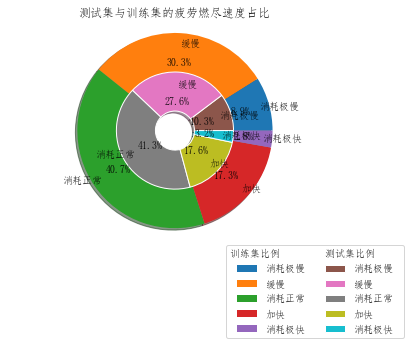

In [8]:
# 饼图
#预测疲劳程度的比例
p_percent = cul_percent(rf_pred)
#实际疲劳程度的比例
t_percent = cul_percent(Test_y.values)
# 状态标签
labels = ['消耗极慢', '缓慢', '消耗正常', '加快', '消耗极快']

plt.pie(p_percent, labels=labels,
        autopct="%.1f%%", 
        shadow=True,
        pctdistance= 0.7,
        labeldistance=0.9,
        wedgeprops=dict(width=0.4))
plt.pie(t_percent, labels=labels,
        autopct="%.1f%%", 
        pctdistance= 0.5,
        shadow = True,
        labeldistance=0.8,
        radius=0.6,
        wedgeprops=dict(width=0.4, edgecolor='w'))

plt.axis('equal')
plt.title('测试集与训练集的疲劳燃尽速度占比')
plt.legend(ncol=2, bbox_to_anchor=(1.2,0), title='训练集比例         测试集比例     ')
plt.savefig('饼图')
plt.show()




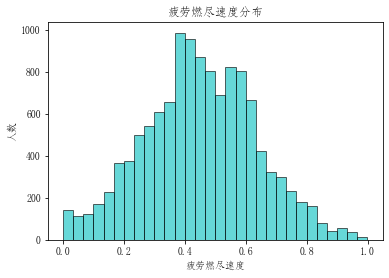

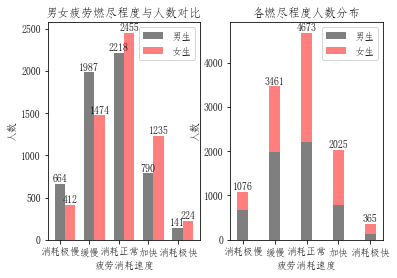

结论：
1、大部分人疲劳燃尽速度保持在0.6以下，属于正常消耗速度，少部分成员疲劳燃尽速度大于0.6，对这部分人要减少工作分配和工作时间，过高的疲劳燃尽速度会导致员工过快进入疲劳程度，在疲劳程度下工作效率极低，因此分配工作是要考虑疲劳消耗程度，让员工保持良好的工作状态。
2、男性和女性的在同一工作量和工作时间下，女性的疲劳消耗速度会大于男性，在分配工作量时可以适度减少女性的工作量，保持合理疲劳消耗程度。


In [10]:
# 用预测模型对新数据进行预测

# 导入数据并清洗
data = pd.read_csv('test.csv')
pre_data = brush(data)


# 数据标准化
pre_data = pd.DataFrame(ss.transform(pre_data), columns=pre_data.columns)
# print(pre_data.columns)
girl_data = []

# 总数据预测
total_pre = model_rf.predict(pre_data)
# print(pre_data.head())

# 划分成男女两个数据集
sex = pre_data['Gender'].unique()
girl_data = pre_data[pre_data['Gender'].isin([sex[0]])]
boy_data = pre_data[pre_data['Gender'].isin([sex[1]])]

# 对男女数据集进行预测
pre_girl = model_rf.predict(girl_data)
pre_boy = model_rf.predict(boy_data)
# print(len(pre_girl), len(pre_boy))

# 调用疲劳消耗速度划分方法，对男生和女生前5800条数据按状态进行比例划分
girl_per = cul_percent(pre_girl[0:5800])
boy_per = cul_percent(pre_boy[0:5800])
# print(girl_per, boy_per)


# 直方图
plt.hist(total_pre, 30, edgecolor='k', facecolor='c', alpha=0.6)
plt.title('疲劳燃尽速度分布')
plt.xlabel('疲劳燃尽速度')
plt.ylabel('人数')
plt.show()


# 条形图
plt.subplot(121)
x = np.arange(5)
bar_width = 0.35
plt.bar(x, girl_per, bar_width, color='k', alpha=0.5)
plt.bar(x+bar_width, boy_per, bar_width, color='r', alpha=0.5)
for i in range(5):
    plt.text(x[i], girl_per[i], '%d' % girl_per[i], ha='center', va='bottom')
    plt.text(x[i]+bar_width, boy_per[i], '%d' % boy_per[i], ha='center', va='bottom')
plt.xticks(x, labels)
plt.xlabel('疲劳消耗速度')
plt.ylabel('人数')
plt.legend(['男生', '女生'])
plt.title('男女疲劳燃尽程度与人数对比')

plt.subplot(122)
plt.bar(x, girl_per, bar_width, color='k', alpha=0.5)
plt.bar(x, boy_per, bar_width, bottom=girl_per, color='r', alpha=0.5)
for i in range(5):
    plt.text(x[i], girl_per[i]+boy_per[i], '%d' % (girl_per[i]+boy_per[i]), ha='center', va='bottom')
plt.xticks(x, labels)
plt.xlabel('疲劳消耗速度')
plt.ylabel('人数')
plt.legend(['男生', '女生'])

plt.title('各燃尽程度人数分布')
plt.show()

print('结论：\
\n1、大部分人疲劳燃尽速度保持在0.6以下，属于正常消耗速度，\
少部分成员疲劳燃尽速度大于0.6，对这部分人要减少工作分配和工作时间，\
过高的疲劳燃尽速度会导致员工过快进入疲劳程度，在疲劳程度下工作效率极低，\
因此分配工作是要考虑疲劳消耗程度，让员工保持良好的工作状态。\
\n2、男性和女性的在同一工作量和工作时间下，女性的疲劳消耗速度会大于男性，\
在分配工作量时可以适度减少女性的工作量，保持合理疲劳消耗程度。')